# Test model with NDS

In [1]:
import sys
sys.path.append("..")
sys.path.append("../../")
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

In [18]:
img_height = 5
img_width = 5
min_blobs = 1
max_blobs = 9
output_size = 15
num_labels = max_blobs - min_blobs + 1
num_sequences = 1000
num_runs = 10

n_hidden = img_height*img_width
unit_std = 0.3 # standard deviation for activated units
all_indices = [x for x in range(0, n_hidden)] # possible activated unit position

In [3]:
NDS_data = np.load("/home/mtfang/increments_copy/NDS_simple_data.npy")
NDS_data = NDS_data.item()
images = NDS_data["images"] # size: (1000,10,10000)
label_saclar = NDS_data["label_scalar"] 

# Test NDS with checkpoints

- original model code: /home/mtfang/DRAM/softmax_model_run.py
- checkpoints path: /home/mtfang/DRAM/softmax_model_sd0.3_const(decrs)fN_ext/

In [198]:
# parameters
dims = [img_height,img_width] # input_img size
batch_size = 1
iter_num = 1000000
MODELNAME = ['constfN', 'decrsfN']
MODE = MODELNAME[1]

In [199]:
def linear(x, w, b):
    output = np.matmul(x, w) + b
    return output

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x) # only difference

In [200]:
confidence = np.zeros([num_runs, num_sequences, num_labels+1, output_size])
estimate = np.zeros([num_runs, num_sequences, num_labels+1]) # estimate of NDS: e(n,s)
difference = np.zeros([num_runs, num_sequences, num_labels]) # differences between consecutive d(n,s)=e(n,s)-e(n-1,s)

print("MODE(classifier):", MODE)
for run_idx in range(num_runs):
    test_run = run_idx + 1
    print("run:", test_run)
    ckpt_file = "/home/mtfang/DRAM/softmax_model_sd0.3_"+MODE+"_ext/softmax_model_run_"+str(test_run)+"/softmax_model_data_run"+str(test_run)+"_epoch"+str(iter_num)+".ckpt"
    # load pre-trained model
    ckpt_reader = tf.train.load_checkpoint(ckpt_file)
    vars_list = tf.train.list_variables(ckpt_file)
    output_w = ckpt_reader.get_tensor("Variable") # size(25, 15)
    output_b = ckpt_reader.get_tensor("Variable_1") # size(15)
    for s_idx in range(num_sequences): 
        for n_idx in range(num_labels+1):
            x = images[s_idx][n_idx]
            classification = softmax(linear(x, output_w, output_b))
            confidence[run_idx][s_idx][n_idx] = classification
            estimate[run_idx][s_idx][n_idx] = np.argmax(classification) + 1
            if n_idx != 0:
                difference[run_idx][s_idx][n_idx-1] = estimate[run_idx][s_idx][n_idx]-estimate[run_idx][s_idx][n_idx-1]
print("Done!")

MODE(classifier): decrsfN
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
run: 10
Done!


In [201]:
np.save("/home/mtfang/increments_copy/data_NDS/simple_softmax_data/simple_softmax_"+MODE+"_confidence.npy", confidence)
np.save("/home/mtfang/increments_copy/data_NDS/simple_softmax_data/simple_softmax_"+MODE+"_estimate.npy", estimate)
np.save("/home/mtfang/increments_copy/data_NDS/simple_softmax_data/simple_softmax_"+MODE+"_difference.npy", difference)

In [202]:
# the mean md(n) and standard deviation sdd(n) of d(n,s) over a population of sequences s
md_n = np.mean(difference, axis=1) 
sdd_n = np.std(difference, axis=1, ddof=1)
# c(n,n-1): the correlation of the variability in the n'th difference with the preceding difference
c_n = np.zeros([num_runs, num_labels-1])
for run_idx in range(num_runs):
    for n_idx in range(1, num_labels):
        d_n = difference[run_idx,:,n_idx]
        m_n = md_n[run_idx][n_idx]
        sd_n = sdd_n[run_idx][n_idx]
        
        d_n_1 = difference[run_idx,:,n_idx-1]
        m_n_1 = md_n[run_idx][n_idx-1]
        sd_n_1 = sdd_n[run_idx][n_idx-1]
        
        #c_n[run_idx][n_idx-1] = np.mean((d_n-m_n)*(d_n_1-m_n_1))/(sd_n*sd_n_1)
        c_n[run_idx][n_idx-1] = np.corrcoef(difference[run_idx,:,n_idx], difference[run_idx,:,n_idx-1])[0,1]

# Curve Fitting

In [203]:
import math
import scipy.stats as st
import scipy.optimize as opt


def powfit(x, slope, power):
    y = slope * np.power(x, power) 
    return y


def get_powreg(cvals, eouts=range(2,10)):
    """Get power curve of best fit, comparing expected number of blobs to actual number of blobs output."""
    
    slopes = np.zeros(num_runs)
    powers = np.zeros(num_runs)
    
    for run in range(num_runs):
        aouts = np.array([cvals[run,eout-min_blobs-1] for eout in eouts])
        popt, pcov = opt.curve_fit(powfit, eouts, aouts, [1,1], maxfev=2000)
        slopes[run], powers[run] = popt

    return slopes, powers

def get_powreg_msdcv(cvals, eouts=range(1,10)):
    """Get power curve of best fit, comparing expected number of blobs to actual number of blobs output."""
    
    slopes = np.zeros(num_runs)
    powers = np.zeros(num_runs)
    
    for run in range(num_runs):
        aouts = np.array([cvals[run,eout-min_blobs] for eout in eouts])
        popt, pcov = opt.curve_fit(powfit, eouts, aouts, [1,1], maxfev=2000)
        slopes[run], powers[run] = popt

    return slopes, powers

def get_CI(vals):
    """Get the 95% confidence intervals."""
    n = len(vals)
    mean = np.mean(vals)
    sd = np.std(vals)
    hw = 1.96*sd/math.sqrt(n)
#     print("CI: (" + str(mean - hw) + ", " + str(mean + hw) + ")")
    return round(mean, 4), round(hw, 4)

In [204]:
def plot_stats_diff(cval): 
    
    cval_subset = cval[:,1:9] # N=1-9
    
    smu = np.mean(cval_subset,axis=0)
    smin = np.min(cval_subset,axis=0)
    smax = np.max(cval_subset,axis=0)
    
    #fig, ax = plt.subplots(1,1)
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    x = [2,3,4,5,6,7,8,9]

    tstr = 'Iter = ' + str(iter_num)
    ax.set_title(tstr)
    ax.plot(x,smu,'k-')
    ax.fill_between(x,smin,smax, facecolor='orange')
        
    ax.set_xlim(1, 10)
    ax.set_ylim(0, 3)
    ax.set_xticks(x)
    #ax.set_yticks(x)
    ax.set_xlabel('n', fontsize=15)
        
    b, c = get_powreg(cval_subset)
    b_mean, b_hw = get_CI(b)
    c_mean, c_hw = get_CI(c)
            
    #for j in range(num_runs):
    #    print("run:%d, b=%.3f, c=%.3f" % (j+1,b[j],c[j]))
        
    ax.text(0.75, .6, 'Curve Fitting:\n' + \
            '$b: ' + str(b_mean) + ' \pm ' + str(b_hw) + \
            '$ \n $c: ' + str(c_mean) + ' \pm ' + str(c_hw) + '$',
            horizontalalignment='center',
            verticalalignment='bottom',
            transform=ax.transAxes)

    popt = [b_mean,c_mean]
    ax.plot(x, powfit(x, *popt), 'r--',label='fit: b=%5.3f, c=%5.3f' % tuple(popt))
        
    ax.set_aspect('equal', 'box')
    ax.grid(True)

plt.show()

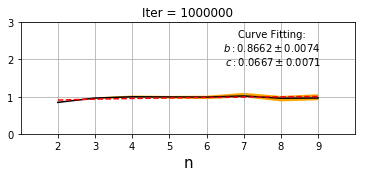

In [205]:
plot_stats_diff(md_n)

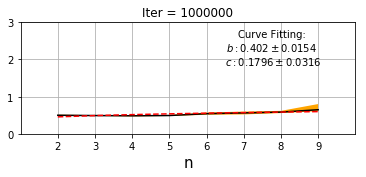

In [206]:
plot_stats_diff(sdd_n)

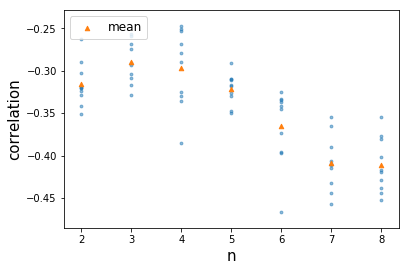

In [207]:
x_c = [2,3,4,5,6,7,8]
plt.scatter(x_c*num_runs, np.reshape(c_n[:,1:8], [1,-1]), s=8, alpha=0.5)
plt.scatter(x_c, np.mean(c_n[:,1:8],0), s=20, marker='^', label="mean")
plt.legend(loc='upper left', fontsize=12)
plt.xlabel("n", fontsize=15)
plt.ylabel("correlation", fontsize=15)

## Mean, Std, and CV

In [208]:
def plot_stats_mu(cval): 
    
    cval_subset = cval[:,1:10] # N=1-9
    
    smu = np.mean(cval_subset,axis=0)
    smin = np.min(cval_subset,axis=0)
    smax = np.max(cval_subset,axis=0)
    
    #fig, ax = plt.subplots(1,1)
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    x = [1,2,3,4,5,6,7,8,9]
    y = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

    tstr = 'Iter = ' + str(iter_num)
    ax.set_title(tstr)
    ax.plot(x,smu,'k-')
    ax.fill_between(x,smin,smax, facecolor='orange')
        
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 15)
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xlabel('n', fontsize=15)
        
    b, c = get_powreg_msdcv(cval_subset)
    b_mean, b_hw = get_CI(b)
    c_mean, c_hw = get_CI(c)
            
    #for j in range(num_runs):
    #    print("run:%d, b=%.3f, c=%.3f" % (j+1,b[j],c[j]))
        
    ax.text(0.75, .7, 'Curve Fitting:\n' + \
            '$b: ' + str(b_mean) + ' \pm ' + str(b_hw) + \
            '$ \n $c: ' + str(c_mean) + ' \pm ' + str(c_hw) + '$',
            horizontalalignment='center',
            verticalalignment='bottom',
            transform=ax.transAxes)

    popt = [b_mean,c_mean]
    ax.plot(x, powfit(x, *popt), 'r--',label='fit: b=%5.3f, c=%5.3f' % tuple(popt))
        
    ax.set_aspect('equal', 'box')
    ax.grid(True)

plt.show()


def plot_stats_std(cval): 
    
    cval_subset = cval[:,1:10] # N=1-9
    
    smu = np.mean(cval_subset,axis=0)
    smin = np.min(cval_subset,axis=0)
    smax = np.max(cval_subset,axis=0)
    
    #fig, ax = plt.subplots(1,1)
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    x = [1,2,3,4,5,6,7,8,9]
    y = [0,1,2,3]

    tstr = 'Iter = ' + str(iter_num)
    ax.set_title(tstr)
    ax.plot(x,smu,'k-')
    ax.fill_between(x,smin,smax, facecolor='orange')
        
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 3)
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xlabel('n', fontsize=15)
        
    b, c = get_powreg_msdcv(cval_subset)
    b_mean, b_hw = get_CI(b)
    c_mean, c_hw = get_CI(c)
            
    #for j in range(num_runs):
    #    print("run:%d, b=%.3f, c=%.3f" % (j+1,b[j],c[j]))
        
    ax.text(0.75, .5, 'Curve Fitting:\n' + \
            '$b: ' + str(b_mean) + ' \pm ' + str(b_hw) + \
            '$ \n $c: ' + str(c_mean) + ' \pm ' + str(c_hw) + '$',
            horizontalalignment='center',
            verticalalignment='bottom',
            transform=ax.transAxes)

    popt = [b_mean,c_mean]
    ax.plot(x, powfit(x, *popt), 'r--',label='fit: b=%5.3f, c=%5.3f' % tuple(popt))
        
    ax.set_aspect('equal', 'box')
    ax.grid(True)

plt.show()


def plot_stats_cv(cval): 
    
    cval_subset = cval[:,1:10] # N=1-9
    
    smu = np.mean(cval_subset,axis=0)
    smin = np.min(cval_subset,axis=0)
    smax = np.max(cval_subset,axis=0)
    
    #fig, ax = plt.subplots(1,1)
    fig, ax = plt.subplots(1, 1)
    x = [1,2,3,4,5,6,7,8,9]
    y = [0,0.5,1.0,1.5,2.0]

    tstr = 'Iter = ' + str(iter_num)
    ax.set_title(tstr)
    ax.plot(x,smu,'k-')
    ax.fill_between(x,smin,smax, facecolor='orange')
        
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 2)
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xlabel('n', fontsize=15)
        
    b, c = get_powreg_msdcv(cval_subset)
    b_mean, b_hw = get_CI(b)
    c_mean, c_hw = get_CI(c)
            
    #for j in range(num_runs):
    #    print("run:%d, b=%.3f, c=%.3f" % (j+1,b[j],c[j]))
        
    ax.text(0.75, .2, 'Curve Fitting:\n' + \
            '$b: ' + str(b_mean) + ' \pm ' + str(b_hw) + \
            '$ \n $c: ' + str(c_mean) + ' \pm ' + str(c_hw) + '$',
            horizontalalignment='center',
            verticalalignment='bottom',
            transform=ax.transAxes)

    popt = [b_mean,c_mean]
    ax.plot(x, powfit(x, *popt), 'r--',label='fit: b=%5.3f, c=%5.3f' % tuple(popt))
        
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    #fig.set_size_inches()

plt.show()

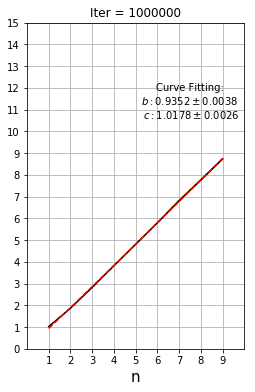

In [209]:
mu_n = np.mean(estimate, axis=1)
plot_stats_mu(mu_n)

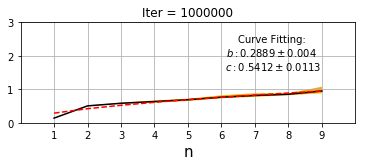

In [210]:
std_n = np.std(estimate, axis=1, ddof=1)
plot_stats_std(std_n)

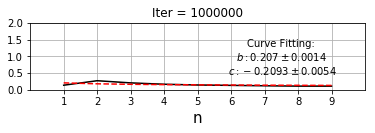

In [211]:
cv_n = std_n/mu_n
plot_stats_cv(cv_n)

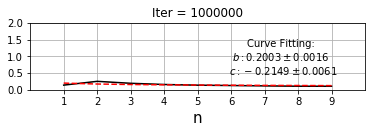

In [212]:
true_mu = [1,1,2,3,4,5,6,7,8,9]
cv_n_2 = std_n/true_mu
plot_stats_cv(cv_n_2)